<a href="https://colab.research.google.com/github/supertime1/Speech_Emotion_Recognition/blob/main/SER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Import dependencies

In [1]:
import os
os.chdir('C:/Users/57lzhang.US04WW4008/PycharmProjects/Speech_Emotion_Recognition')
from data_handler import *
from audio_processor import AudioProcessor
import tensorflow as tf
import librosa.display
import matplotlib.pyplot as plt
import sklearn
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D, Conv1D, BatchNormalization, Input, Add, Activation, \
    MaxPooling1D, Dropout, Flatten, TimeDistributed, Bidirectional, Dense, LSTM, ZeroPadding1D, \
    AveragePooling1D, GlobalAveragePooling1D, Concatenate, Permute, Dot, Multiply, RepeatVector, \
    Lambda, Average, GlobalAveragePooling2D, DepthwiseConv2D, MaxPooling2D, ZeroPadding2D

In [ ]:
 ##to overwrite NCCL cross device communication as this is running in Windows
strategy = tf.distribute.MirroredStrategy(cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


# Test with speech recognition data

In [ ]:
import os
import numpy as np
import librosa
import tensorflow as tf
import argparse
import soundfile as sf
import glob

"""
Notes:
1. In oder to use DataHandler, the data should be stored as db_name/raw_data.
For example, RAVDESS raw data should be stored as RAVDESS/raw_data/Actor_01/*.wav;
EMODB raw data should be stored as EMODB/raw_data/*.wav;
2. functions with name that end with _tensor are for building tensorflow graphs purpose;
for standard python operation, use the non-tensor counterparts 
"""


class DataHandlers:

    def __init__(self, raw_data_path: str, train_ratio: float, val_ratio: float, res_freq: int,
                 block_span: int, stride_span: int, random_seed: int, db_name: str):
        self.raw_data_path = raw_data_path
        self.train_ratio = train_ratio
        self.val_ratio = val_ratio
        self.res_freq = res_freq
        self.block_span = block_span
        self.stride_span = stride_span
        self.random_seed = random_seed
        self.fn_dic = {}
        self.train_fn_dic = {}
        self.val_fn_dic = {}
        self.test_fn_dic = {}
        self.db_name = db_name
        self._create_block_fn()

    def _create_block_fn(self):
        """
        :return: generators and dictionaries containing train, validation and test data
        """
        if self.db_name == 'RAVDESS':
            # e.g. folder: Actor_01
            for folder in os.listdir(self.raw_data_path):
                # e.g. data_path: data/Actor_01
                data_path = os.path.join(self.raw_data_path, folder)
                fn_lst = os.listdir(data_path)
                for idx in range(len(fn_lst)):
                    # e.g. fn_path: data/Actor_01/03-01-01-01-01-01-02.wav
                    fn_path = os.path.join(data_path, fn_lst[idx])
                    label = int(fn_lst[idx][6:8]) - 1
                    if label not in self.fn_dic:
                        self.fn_dic[label] = [fn_path]
                    else:
                        self.fn_dic[label].append(fn_path)
                # fn_dic is created to be {'00':[*.wav], '01':[*.wav], ...}

                for label, fn_lst in self.fn_dic.items():
                    np.random.seed(seed=self.random_seed)
                    np.random.shuffle(fn_lst)
                    self.val_fn_dic[label] = fn_lst[:int(self.train_ratio * self.val_ratio * len(fn_lst))]
                    self.train_fn_dic[label] = fn_lst[int(self.train_ratio * self.val_ratio * len(fn_lst)):
                                                      int(self.train_ratio * len(fn_lst))]
                    self.test_fn_dic[label] = fn_lst[int(self.train_ratio * len(fn_lst)):]

        if self.db_name == 'EMODB':
            for fn in os.listdir(self.raw_data_path):
                fn_path = os.path.join(self.raw_data_path, fn)
                # W: anger; L: boredom; E: disgust; A: anxiety/fear; F: happiness; T: sadness;
                # N: neutral
                conversion_dict = {'W': 0, 'L': 1, 'E': 2, 'A': 3,
                                   'F': 4, 'T': 5, 'N': 6}
                label = conversion_dict[fn[5]]
                if label not in self.fn_dic:
                    self.fn_dic[label] = [fn_path]
                else:
                    self.fn_dic[label].append(fn_path)

            for label, fn_lst in self.fn_dic.items():
                np.random.seed(seed=self.random_seed)
                np.random.shuffle(fn_lst)
                self.val_fn_dic[label] = fn_lst[:int(self.train_ratio * self.val_ratio * len(fn_lst))]
                self.train_fn_dic[label] = fn_lst[int(self.train_ratio * self.val_ratio * len(fn_lst)):
                                                  int(self.train_ratio * len(fn_lst))]
                self.test_fn_dic[label] = fn_lst[int(self.train_ratio * len(fn_lst)):]

    def create_label_folder(self):
        self._convert_to_block(self.train_fn_dic, 'train')
        self._convert_to_block(self.val_fn_dic, 'val')
        self._convert_to_block(self.test_fn_dic, 'test')

        # if do_train_val_split:
        #   val_path = os.path.join('data', 'val')
        #   if not os.path.exists(val_path):
        #       os.mkdir(val_path)
        #   train_path = os.path.join('data', 'train')
        #   for label_path in os.listdir(train_path):
        #       # e.g. train_label_path: data/train/0/
        #       train_label_path = os.path.join(train_path, label_path, '*.wav')
        #       fn_lst = glob.glob(train_label_path)

    #
    #       np.random.seed(seed=self.random_seed)
    #       np.random.shuffle(fn_lst)
    #       val_fn_lst = fn_lst[:int(len(fn_lst) * self.val_ratio)]
    #       target_val_fn_path = os.path.join(val_path, label_path)
    #       if not os.path.exists(target_val_fn_path):
    #           os.mkdir(target_val_fn_path)
    #       for val_fn in val_fn_lst:
    #           parts = val_fn.split(os.path.sep)
    #           wav_fn = parts[-1]
    #           shutil.move(val_fn, os.path.join(target_val_fn_path, wav_fn))

    def _convert_to_block(self, name_fn_dic, name):
        # e.g. data_root: RAVDESS/data
        data_root = os.path.join(self.db_name, 'data')
        if not os.path.exists(data_root):
            os.mkdir(data_root)

        print(f'\nCreating {name} data...')
        # e.g. name_path: RVDESS/data/train
        name_path = os.path.join(data_root, name)
        if not os.path.exists(name_path):
            os.mkdir(name_path)

        # e.g. fn_lst: [RAVDESS/raw_data/Actor_01/03-01-01-01-01-01-02.wav, data/Actor_02/*.wav, ...]
        for label, fn_lst in name_fn_dic.items():
            print(f'\nProcessing {name} label {label}..')
            # e.g. label_folder_path: RAVDESS/data/train/0
            label_folder_path = os.path.join(name_path, str(label))
            if not os.path.exists(label_folder_path):
                os.mkdir(label_folder_path)
            for i in range(len(fn_lst)):
                if i % 10 == 0:
                    print(f'working on {i}th file')
                y, sr = librosa.load(fn_lst[i], sr=self.res_freq)
                signal, _ = librosa.effects.trim(y)
                block_len = self.res_freq * self.block_span
                stride_len = int(self.res_freq * self.stride_span / 1000)
                for j in range(0, len(signal), stride_len):
                    if j + block_len > len(signal):
                        break
                    block_signal = signal[i:i + block_len]
                    parts = fn_lst[i].split(os.path.sep)
                    sf.write(label_folder_path + '/' + parts[-1][:-4] + '_' + str(j) + '.wav',
                             block_signal, self.res_freq)

    def calculate_mean_std(self):
        """
        Calculate the mean and standard deviation of the train audio waveform,
        this will be useful to normalize the input data to the model
        """
        def waveform_generator(filename_dic: dict):
            for _, fn_lst in filename_dic.items():
                for fn in fn_lst:
                    signal, _ = librosa.load(fn, sr=None)
                    yield signal

        signals = waveform_generator(self.train_fn_dic)
        n = 0
        # need to record both E(x) and E(x**2) to calculate Variance (aka. std**2)
        Sum = square_Sum = 0
        for signal in signals:
            Sum += np.sum(signal)
            square_signal = np.square(signal)
            square_Sum += np.sum(square_signal)
            n += len(signal)

        mean = Sum / n
        square_mean = square_Sum / n
        # Var(X) = E(X**2) - E(X)**2
        std = np.sqrt(square_mean - mean ** 2)
        return mean, std

    @staticmethod
    def get_waveform_and_label(file_path):
        parts = file_path.split(os.path.sep)
        label = int(parts[-2])
        waveform, _ = librosa.load(file_path, sr=None)
        return waveform, label

    def get_waveform_and_label_tensor(self, file_path):
        parts = tf.strings.split(file_path, os.path.sep)
        label = tf.strings.to_number(parts[-2], out_type=tf.float32)
        #label = tf.one_hot(label, 7)
        audio_binary = tf.io.read_file(file_path)
        waveform, _ = tf.audio.decode_wav(audio_binary)
        waveform = tf.reshape(waveform, [self.block_span * self.res_freq])
        return waveform, label

    @staticmethod
    def get_filenames(data_dir):
        filenames = glob.glob(str(data_dir) + '/*/*')
        np.random.shuffle(filenames)
        num_samples = len(filenames)
        print('Number of total examples:', num_samples)
        print('Example file:', filenames[:20])
        return filenames, num_samples

    @staticmethod
    def get_filenames_tensor(data_dir):
        filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
        filenames = tf.random.shuffle(filenames)
        num_samples = len(filenames)
        print('Number of total examples:', num_samples)
        print('Example file tensor:', filenames[:20])
        return filenames, num_samples

    def count_label(self):
        def _count_labels_from_raw_file(dic):
            for label, fn_lst in dic.items():
                print(f'There are {len(fn_lst)} files with label {label}')

        def _count_block_labels(name: str):
            # e.g. path: 'EMODB/data/train'
            path = os.path.join(self.db_name, 'data', name)
            filenames = glob.glob(path + '/*/*')
            total_num_blocks = len(filenames)
            print(f'There are in total {total_num_blocks} {self.block_span}s blocks')
            for root, labels, _ in os.walk(path):
                for label in labels:
                    file_path = os.path.join(root, label)
                    for _, _, files in os.walk(file_path):
                        print(f'There are {round(len(files) / total_num_blocks, 2) * 100}% '
                              f'files with label {label}')

        print('\nRAW wav files analysis:')
        print('\nIn raw dataset:')
        _count_labels_from_raw_file(self.fn_dic)
        print('\nIn training raw dataset:')
        _count_labels_from_raw_file(self.train_fn_dic)
        print('\nIn validation raw dataset:')
        _count_labels_from_raw_file(self.val_fn_dic)
        print('\nIn testing rwa dataset:')
        _count_labels_from_raw_file(self.test_fn_dic)

        print('\n\n\n Block prospect analysis:')
        print('\nIn training block dataset:')
        _count_block_labels('train')
        print('\nIn validation block dataset:')
        _count_block_labels('val')
        print('\nIn testing block dataset:')
        _count_block_labels('test')
    
        return [_ for _ in self.fn_dic.keys()]

    # TODO: add functions to analyze data feature distributions, and label counts
    # Will rely on audio_processor's feature extraction functions
    def data_feature_analysis(self):
        pass

In [ ]:
class AudioProcessors:
    def __init__(self, sample_freq, slice_span, overlap_ratio, n_mels, snr):
        self.sample_freq = sample_freq
        self.slice_span = slice_span
        self.overlap_ratio = overlap_ratio
        self.n_mels = n_mels
        self.snr = snr

    @property
    def n_per_seg(self):
        return int(self.slice_span / 1000 * self.sample_freq)

    @property
    def n_fft(self):
        return int(pow(2, np.ceil(np.log(self.n_per_seg) / np.log(2))))

    @property
    def hop_length(self):
        return int(self.n_fft * (1 - self.overlap_ratio))

    def add_additive_white_gaussian_noise(self, data, label):
        rms_signal = math.sqrt(np.mean(data ** 2))
        std_noise = abs(rms_signal) / math.sqrt(10 ** (self.snr / 10))
        noise = np.random.normal(0, std_noise, data.shape[0])
        data = data + noise
        return data, label

    def get_add_additive_white_gaussian_noise_tensor(self, data, label):
        data, label = tf.py_function(self.add_additive_white_gaussian_noise,
                                     inp=[data, label],
                                     Tout=[tf.float32, tf.float32])
        data.set_shape(data.shape)
        return data, label

    def spectrogram(self, data, label):
        spec = np.abs(librosa.stft(np.asarray(data), n_fft=self.n_fft,
                                   hop_length=self.hop_length))
        return spec, label

    def get_spectrogram_tensor(self, data, label):
        spectrogram, label = tf.py_function(self.spectrogram, inp=[data, label],
                                            Tout=[tf.float32, tf.int64])
        spectrogram = tf.expand_dims(spectrogram, -1)

        spectrogram.set_shape(spectrogram.shape)
        return spectrogram, label

    def mel_spectrogram(self, data, label):
        mel_spec = librosa.feature.melspectrogram(np.asarray(data),
                                                  sr=self.sample_freq,
                                                  n_fft=self.n_fft,
                                                  hop_length=self.hop_length,
                                                  n_mels=self.n_mels)
        return mel_spec, label

    def get_mel_tensor(self, data, label):
        mel_spec, label = tf.py_function(self.mel_spectrogram, inp=[data, label],
                                         Tout=[tf.float32, tf.int64])
        mel_spec = tf.expand_dims(mel_spec, -1)

        mel_spec.set_shape(mel_spec.shape)
        return mel_spec, label

In [ ]:
# import data generator
raw_data_path = 'EMODB/raw_data'
train_ratio = 0.9
val_ratio = 0.1
block_span = 1 # second
stride_span = 10 # millisecond
res_freq = 16000
random_seed = 10
db_name = 'EMODB'

data_handler = DataHandlers(raw_data_path, train_ratio, val_ratio, 
                        res_freq, block_span, stride_span, random_seed,
                        db_name)

sample_freq = res_freq
slice_span = 16 # millisecond
overlap_ratio = 3/4
n_mels = 64
snr = 20
audio_processor = AudioProcessors(sample_freq, slice_span, overlap_ratio, n_mels, snr)

In [ ]:
import pathlib

data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


In [ ]:
filenames, num_samples = data_handler.get_filenames_tensor(data_dir)

Number of total examples: 8000
Example file tensor: tf.Tensor(
[b'data\\mini_speech_commands\\left\\338dacf5_nohash_1.wav'
 b'data\\mini_speech_commands\\up\\cb2929ce_nohash_1.wav'
 b'data\\mini_speech_commands\\stop\\24ed94ab_nohash_2.wav'
 b'data\\mini_speech_commands\\no\\5628d7b7_nohash_1.wav'
 b'data\\mini_speech_commands\\no\\c84f9b5c_nohash_0.wav'
 b'data\\mini_speech_commands\\down\\742d6431_nohash_0.wav'
 b'data\\mini_speech_commands\\go\\ab76ac76_nohash_0.wav'
 b'data\\mini_speech_commands\\left\\c22d3f18_nohash_3.wav'
 b'data\\mini_speech_commands\\no\\ac7840d8_nohash_1.wav'
 b'data\\mini_speech_commands\\left\\c120e80e_nohash_2.wav'
 b'data\\mini_speech_commands\\yes\\9a4d12fd_nohash_1.wav'
 b'data\\mini_speech_commands\\yes\\93ec8b84_nohash_0.wav'
 b'data\\mini_speech_commands\\up\\8ec6dab6_nohash_0.wav'
 b'data\\mini_speech_commands\\stop\\c0fb6812_nohash_0.wav'
 b'data\\mini_speech_commands\\go\\28ce0c58_nohash_2.wav'
 b'data\\mini_speech_commands\\yes\\4f2ab70c_nohash_4

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  label_id = tf.argmax(label == commands)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  return equal_length, label_id

In [ ]:
def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label,
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
    output_ds = output_ds.map(audio_processor.get_mel_tensor,
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return output_ds

In [ ]:
batch_size = 64
train_ds = preprocess_dataset(train_files)
spectrogram_ds = train_ds
val_ds = preprocess_dataset(val_files)
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# calculate the input shape, which is needed to initialize keras model
sample_data = np.random.rand((block_span * res_freq))
sample_mel, _ = audio_processor.mel_spectrogram(sample_data, 1)
sample_mel = np.expand_dims(sample_mel, -1)
input_shape = sample_mel.shape

In [ ]:
input_shape

(64, 251, 1)

In [ ]:
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import models
from tensorflow.keras import layers
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

EPOCHS = 30
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)            

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2]

def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label
  
AUTOTUNE = tf.data.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram, label = audio_processor.spectrogram(waveform, label)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)

Label: go
Waveform shape: (16000,)
Spectrogram shape: (129, 251)


#2. Data pipeline

In [2]:
# import data generator
raw_data_path = 'EMODB/raw_data'
train_ratio = 0.9
val_ratio = 0.1
block_span = 1 # second
stride_span = 10 # millisecond
res_freq = 16000
random_seed = 10
db_name = 'EMODB'

data_handler = DataHandler(raw_data_path, train_ratio, val_ratio, 
                        res_freq, block_span, stride_span, random_seed,
                        db_name)

sample_freq = res_freq
slice_span = 16 # millisecond
overlap_ratio = 3/4
n_mels = 64
snr = 20
audio_processor = AudioProcessor(sample_freq, slice_span, overlap_ratio, n_mels, snr)

In [145]:
test_path = os.path.join(db_name, 'data', 'test')
test_fn, _ = DataHandler.get_filenames(test_path)
test_ds = [DataHandler.get_waveform_and_label(_) for _ in test_fn]

Number of total examples: 9890
Example file: ['EMODB\\data\\test\\6\\03b09Nc_12160.wav', 'EMODB\\data\\test\\2\\03b10Ec_4000.wav', 'EMODB\\data\\test\\6\\09b09Nd_8480.wav', 'EMODB\\data\\test\\0\\14b01Wc_15520.wav', 'EMODB\\data\\test\\3\\14b01Ac_14720.wav', 'EMODB\\data\\test\\1\\08a05Lc_19360.wav', 'EMODB\\data\\test\\6\\03b10Na_2720.wav', 'EMODB\\data\\test\\0\\09a05Wb_4960.wav', 'EMODB\\data\\test\\6\\11b03Nb_21120.wav', 'EMODB\\data\\test\\4\\11a05Fc_5600.wav', 'EMODB\\data\\test\\4\\11a05Fc_27680.wav', 'EMODB\\data\\test\\1\\08a05Lc_16320.wav', 'EMODB\\data\\test\\5\\08a05Ta_45120.wav', 'EMODB\\data\\test\\6\\03b10Na_1280.wav', 'EMODB\\data\\test\\0\\16a01Wb_5120.wav', 'EMODB\\data\\test\\5\\03a02Ta_8960.wav', 'EMODB\\data\\test\\5\\08a05Ta_29760.wav', 'EMODB\\data\\test\\2\\13a01Ec_19040.wav', 'EMODB\\data\\test\\2\\10b01Ea_5440.wav', 'EMODB\\data\\test\\2\\14b09Ea_43520.wav']


In [146]:
test_ds = [audio_processor.get_spectrogram(waveform, label) for waveform, label in test_ds]

In [147]:
test_data_lst, test_label_lst = zip(*[audio_processor.spectrogram_to_rgb(spec, label) for spec, label in test_ds])

In [150]:
test_data = np.asarray(test_data_lst)
test_label = np.asarray(test_label_lst)

In [19]:
model = tf.keras.models.load_model('artifacts/models/ft_mobile_net_v2')

In [151]:
test_pred_raw = model.predict(test_data)

In [152]:
test_pred = np.argmax(test_pred_raw, axis=-1)


In [154]:
cm = sklearn.metrics.confusion_matrix(test_label, test_pred)


In [159]:
class_names = ['Anger', 'Boredom', 'Disgust', 'Anxiety',
                           'Happiness', 'Sadness', 'Neutral']

In [182]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import io
import itertools


def plot_confusion_matrix1(cm, class_names, normalize=False):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """

    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    plt.ylim(bottom=-0.5, top=6.5)

    if normalize:
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 1.5

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

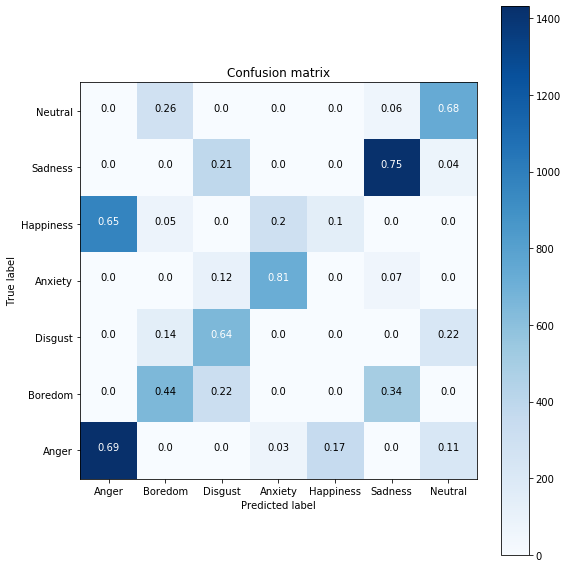

In [183]:
figure = plot_confusion_matrix1(cm, class_names=class_names, normalize=True)


Check spectrogram and mel-spectrogram

1


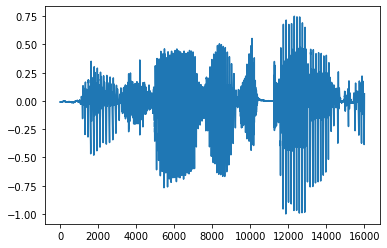

In [3]:
waveform, label = data_handler.get_waveform_and_label(r'C:\Users\57lzhang.US04WW4008\PycharmProjects\Speech_Emotion_Recognition\EMODB\data\train\1\03a07La_320.wav')
plt.plot(waveform)
print(label)


In [11]:
np.size(spectrogram) == 129 * 251

True

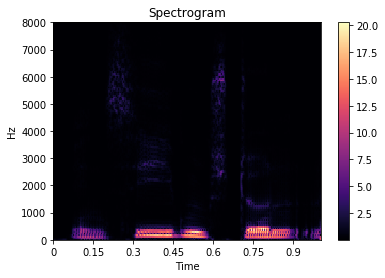

Spectrogram shape: (129, 251)


In [4]:
spectrogram, label = audio_processor.get_spectrogram(waveform, label)
#spec_in_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
librosa.display.specshow(spectrogram, sr=16000, hop_length=audio_processor.hop_length, x_axis='time', y_axis='linear');
plt.colorbar();
plt.title('Spectrogram')
plt.show()
print(f'Spectrogram shape: {spectrogram.shape}')

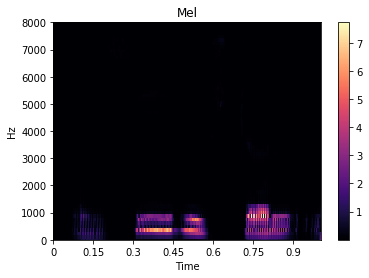

Mel spectrogram shape: (64, 251)


In [ ]:
mel, label = audio_processor.get_mel_spectrogram(waveform, label)
librosa.display.specshow(mel, sr=16000, hop_length=audio_processor.hop_length, 
                         x_axis='time', y_axis='linear');
plt.colorbar();
plt.title('Mel')
plt.show()
print(f'Mel spectrogram shape: {mel.shape}')

Matplotlib approach

In [ ]:
from matplotlib import cm
import matplotlib

#norm = matplotlib.colors.Normalize(vmin=0, vmax=255)
sm = cm.ScalarMappable(norm=None, cmap='jet')
color_spectrogram = sm.to_rgba(spectrogram, norm=False, bytes=True)
print(f'Color spectrogram shape: {color_spectrogram.shape}')

Color spectrogram shape: (129, 251, 4)


In [ ]:
color_spectrogram[:,:,:3].shape

(129, 251, 3)

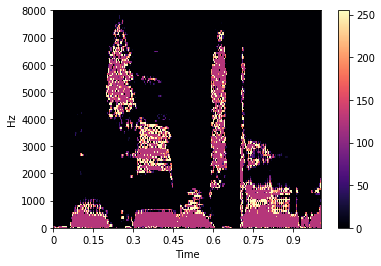

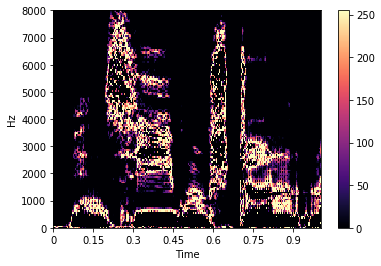

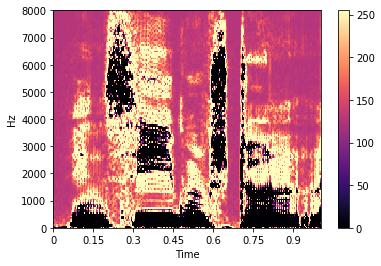

In [ ]:
for i in range(3):
    librosa.display.specshow(color_spectrogram[:,:,i], sr=16000, hop_length=audio_processor.hop_length, x_axis='time', y_axis='linear');
    plt.colorbar();
    plt.show()

In [ ]:
from datetime import datetime, timedelta
a = '122821'
s = 1
b = datetime.strptime(a, '%H%M%S')
c = b + timedelta(seconds=int(s))
(c - datetime(1900, 1, 1)).total_seconds()

44902.0

In [ ]:
c.date()

datetime.date(1900, 1, 1)

In [ ]:

    # get num of classes
    classes_lst = data_handler.count_label()
    num_classes = len(classes_lst)
    print(f'\n\nThere are {num_classes} classes in total....\n\n')

    # calculate the input shape, which is needed to initialize keras modelzoo
    sample_data = np.random.rand((block_span * res_freq))
    sample, _ = audio_processor.get_spectrogram(sample_data, 1)
    #sample = np.expand_dims(sample, -1)
    input_shape = sample.shape
    print(f'\n\nInput data shape: {input_shape}...\n\n')

    # get the train and validation filenames
    train_path = os.path.join(db_name, 'data', 'train')
    val_path = os.path.join(db_name, 'data', 'val')
    train_filenames, _ = data_handler.get_filenames_tensor(train_path)
    val_filenames, _ = data_handler.get_filenames_tensor(val_path)

    # tf.data pipeline
    def preprocess_dataset(files):
        files_ds = tf.data.Dataset.from_tensor_slices(files)
        output_ds = files_ds.map(data_handler.get_waveform_and_label_tensor,
                                 num_parallel_calls=tf.data.experimental.AUTOTUNE)
        output_ds = output_ds.map(audio_processor.get_spectrogram_tensor,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
        output_ds = output_ds.map(audio_processor.spectrogram_to_rgb_tensor,
                                  num_parallel_calls=tf.data.experimental.AUTOTUNE)
        return output_ds


RAW wav files analysis:

In raw dataset:
There are 71 files with label 4
There are 79 files with label 6
There are 127 files with label 0
There are 62 files with label 5
There are 69 files with label 3
There are 81 files with label 1
There are 46 files with label 2

In training raw dataset:
There are 57 files with label 4
There are 64 files with label 6
There are 103 files with label 0
There are 50 files with label 5
There are 56 files with label 3
There are 65 files with label 1
There are 37 files with label 2

In validation raw dataset:
There are 6 files with label 4
There are 7 files with label 6
There are 11 files with label 0
There are 5 files with label 5
There are 6 files with label 3
There are 7 files with label 1
There are 4 files with label 2

In testing raw dataset:
There are 8 files with label 4
There are 8 files with label 6
There are 13 files with label 0
There are 7 files with label 5
There are 7 files with label 3
There are 9 files with label 1
There are 5 files with l

In [ ]:
    train_ds = preprocess_dataset(train_filenames)


In [ ]:
input_shape = list(train_ds.take(1))[0][0].shape

In [ ]:
from modelzoo.models.ft_mobile_net_v2 import FT_Mobile_Net_V2


In [ ]:
type(input_shape)

tensorflow.python.framework.tensor_shape.TensorShape

In [ ]:
model = FT_Mobile_Net_V2(input_shape=input_shape,
                            num_classes=num_classes,
                            dropout=0.5)

model.summary()

Model: "ft_mobile_net_v2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 129, 251, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 129, 251, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 129, 251, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, None, None, 1280)  2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 7)            

##Training

In [ ]:
sample_data = np.random.rand((block_span*res_freq))
sample_mel, _ = audio_processor.mel_spectrogram(sample_data, 1)
sample_mel = np.expand_dims(sample_mel, -1)
input_shape = sample_mel.shape
print(input_shape)

batch_size = 64
epochs = 100
train_filenames, train_num_samples = data_handler.get_filenames('data/train')
val_filenames, val_num_samples = data_handler.get_filenames('data/val')

def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(data_handler.get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
  output_ds = output_ds.map(audio_processor.get_mel_tensor, num_parallel_calls=tf.data.AUTOTUNE)
  return output_ds

train_ds = preprocess_dataset(train_filenames)
val_ds = preprocess_dataset(val_filenames)
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)

## early stop
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                patience=20,
                                                restore_best_weights=True)
## learning rate decay callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(decay)
callback_list = [early_stop, lr_schedule]

AttributeError: ignored

In [ ]:
model = MobileNet(input_shape=input_shape, classes=8)
model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                metrics=[tf.keras.metrics.CategoricalAccuracy()])
history = model.fit(train_ds,
                    epochs=epochs,
                    validation_data=val_ds,
                    verbose=1,
                    callbacks=callback_list
                    )

##visualize the preprocessing

In [ ]:
train_gen = train_data_generator()
testing_data = next(train_gen)[0]

spec = audio_processor.spectrogram(testing_data)
librosa.display.specshow(spec, sr=sample_freq, x_axis='time', y_axis='linear');
plt.colorbar();
plt.title('Spectrogram')
plt.show()


mel_spec = audio_processor.mel_spectrogram(testing_data)
librosa.display.specshow(mel_spec, sr=sample_freq, x_axis='time', y_axis='linear');
plt.colorbar();
plt.title('Mel Spectrogram')
plt.show()